In [2]:
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torchvision.models.efficientnet import efficientnet_b0
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, ToTensor, Normalize

from sklearn.preprocessing import StandardScaler, MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     current_device = torch.cuda.current_device()
#     print(f"Currently using GPU: {current_device}")
# else:
#     print("GPU not available. Using CPU.")

C:\Users\jimmy\AppData\Local\Temp\ipykernel_20440\4016813700.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# not worring about '_sd' columns for now
sd_columns = [col for col in train.columns if col.endswith('_sd')]
train = train.drop(columns=sd_columns)

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

train['image_path'] = 'Input/train_images/' + train['id'].astype(str) + '.jpeg'
test['image_path'] = 'Input/test_images/' + test['id'].astype(str) + '.jpeg'

train.head(5)

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.472432,0.448272,0.403038,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034,Input/train_images/192027691.jpeg
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.279112,0.294724,0.311158,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472,Input/train_images/195542235.jpeg
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,0.455066,0.458448,0.455440,0.796917,5.291251,8.552908,0.395241,2.343153,1130.096731,Input/train_images/196639184.jpeg
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,0.350208,0.349995,0.348838,0.525236,9.568305,1.083629,0.154200,1.155308,1042.686546,Input/train_images/195728812.jpeg
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.488996,0.457526,0.448166,0.411821,14.528877,0.657585,10.919966,2.246226,2386.467180,Input/train_images/195251545.jpeg


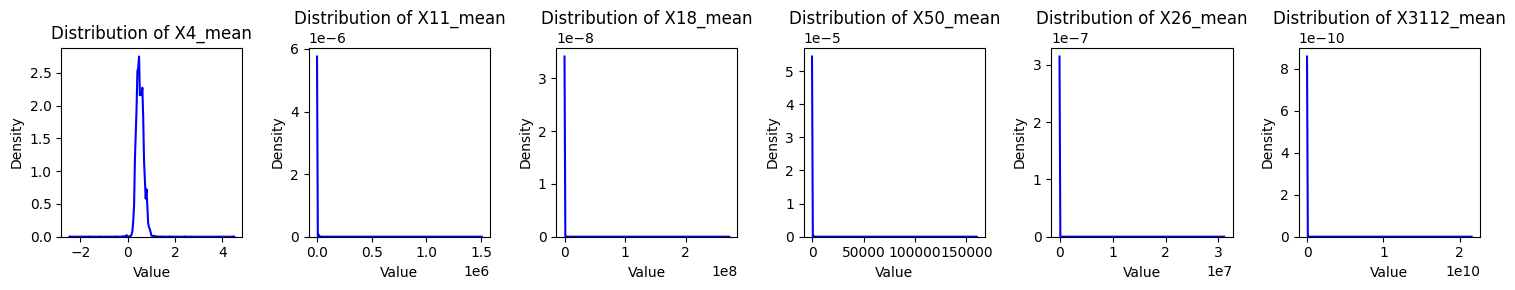

In [3]:
def plot_data(df):
    plt.figure(figsize=(15, 3))

    for i, col in enumerate(mean_columns):
        plt.subplot(1, 6, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

plot_data(train)

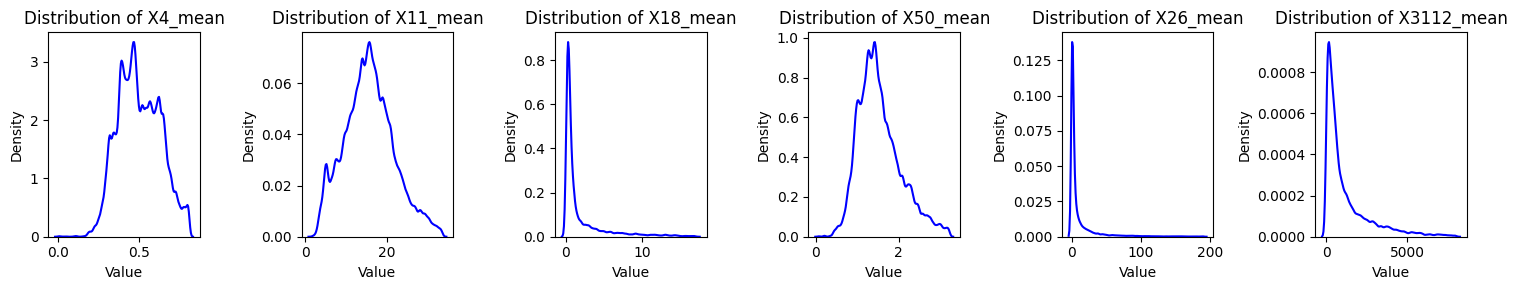

In [5]:
# target cols data too many outliers 
# drop outliers  data

def remove_outliers(df):
    for col in mean_columns:
        upper_quantile = df[col].quantile(0.98) 
        df = df[(df[col] < upper_quantile)]
        df = df[(df[col] > 0)] 
    return df

train = remove_outliers(train)
plot_data(train)

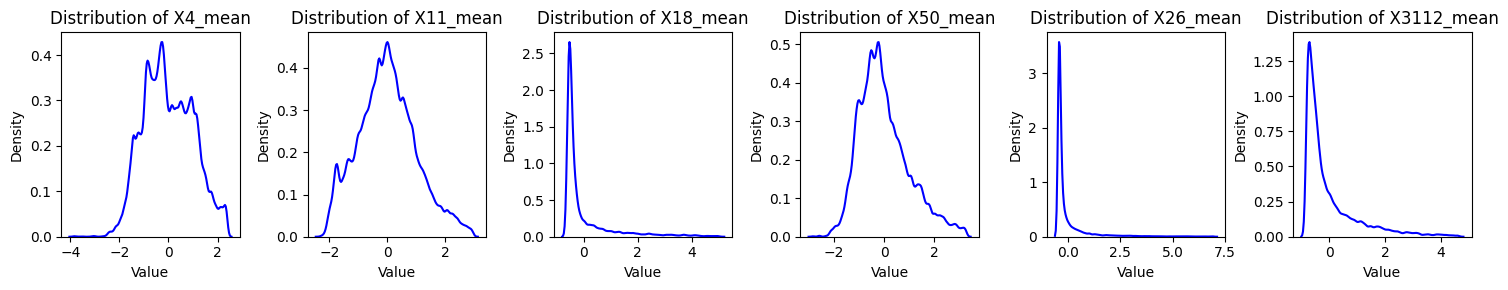

In [6]:
original_means = {}
original_stds = {}

for column in mean_columns:
    original_means[column] = train[column].mean()
    original_stds[column] = train[column].std()

def standardize_data(df):
    scaler = StandardScaler()
    mean_data = df[mean_columns]
    scaled_data = scaler.fit_transform(mean_data)
    df[mean_columns] = scaled_data

    return df
    
train = standardize_data(train)
plot_data(train)

In [7]:
# apply Normalization to ancillary_data
def normalize_data(df, column_names):
    scaler = MinMaxScaler()
    df[column_names] = scaler.fit_transform(df[column_names])
    return df

ancillary_data = train.drop(columns=['id', 'image_path'] + mean_columns)
ancillary_data_columns = ancillary_data.columns

ancillary_data = normalize_data(ancillary_data, ancillary_data_columns)
ancillary_data.head(5)

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
0,0.589812,0.044619,0.025531,0.426087,0.378824,0.457493,0.581818,0.705479,0.591195,0.714286,...,0.575114,0.626286,0.664685,0.617829,0.508444,0.492431,0.527086,0.563307,0.550562,0.509584
1,0.704174,0.010753,0.004227,0.225383,0.421284,0.577709,0.575758,0.671233,0.603774,0.700000,...,0.345149,0.329614,0.328575,0.293476,0.287068,0.288866,0.306226,0.329012,0.357319,0.390336
2,0.635668,0.107486,0.020271,0.105398,0.187548,0.270513,0.472727,0.595890,0.484277,0.578571,...,0.550643,0.542005,0.557043,0.547241,0.508091,0.505871,0.527450,0.542260,0.563369,0.577594
3,0.736208,0.175626,0.066600,0.265415,0.184114,0.228183,0.551515,0.582192,0.522013,0.614286,...,0.418259,0.402210,0.393359,0.368121,0.365837,0.381258,0.375098,0.415178,0.426880,0.439240
4,0.327181,0.063162,0.020767,0.225440,0.651606,0.682751,0.375758,0.684932,0.490566,0.664286,...,0.449685,0.516819,0.582126,0.683623,0.697561,0.714746,0.672821,0.583382,0.562210,0.568153


In [12]:
output = train[mean_columns]
img_path = train['image_path']

# split train test dataframe
train_data, test_data, train_output, test_output = train_test_split(
    ancillary_data, output, test_size=0.2, random_state=42
)

train_img_path, test_img_path = train_test_split(
    img_path, test_size=0.2, random_state=42
)

In [13]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso()
lasso_reg.fit(train_data, train_output)
reg_coef = lasso_reg.coef_
print(reg_coef)

[[ 0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.
  -0.  0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
   0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0. -0. -0.  0.
  -0.  0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0.
  -0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
   0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0.]
 [-0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.
   0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0.  0. -0.
  -0. -0. -0. -0. -0.  0.  0.  

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_paths, ancillary_data, output, transform=None):
        self.img_paths = img_paths
        self.ancillary_data = ancillary_data
        self.output = output
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths.iloc[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        ancillary = self.ancillary_data.iloc[idx].values
        output = self.output.iloc[idx].values
        return image, ancillary, output

img_transforms = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.2, contrast=0.5, hue=0.2, saturation=0.5),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
train_dataset = CustomImageDataset(train_img_path, train_data, train_output, transform=img_transforms)
test_dataset = CustomImageDataset(test_img_path, test_data, test_output, transform=img_transforms)

train_loader = DataLoader(
    train_dataset, 
    batch_size=192, 
    shuffle=True,
    pin_memory=True)
test_loader = DataLoader(
    test_dataset, 
    batch_size=192, 
    shuffle=False,
    pin_memory=True)

In [ ]:
iter_data = iter(train_loader)
image, ancillary, output = next(iter_data)

img = image[13]
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
plt.imshow(img)
print(img.shape)
print("data: ", ancillary)
print("output: ", output)

NameError: name 'train_loader' is not defined

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, effnet_layer, tabular_dense, concat_dense, output_layer):
        super(CustomModel, self).__init__()
        self.effnet_layer = effnet_layer
        self.tabular_dense = tabular_dense
        self.concat_dense = concat_dense
        self.output_layer = output_layer

    def forward(self, image, ancillary):
        effnet_output = self.effnet_layer(image)
        tabular_output = self.tabular_dense(ancillary.to(torch.float32))
        concatenated_output = torch.cat((effnet_output, tabular_output), dim=1)
        concat_dense_output = self.concat_dense(concatenated_output)
        output = self.output_layer(concat_dense_output)
        return output

# Define layers
effnet_layer = efficientnet_b0(weights='IMAGENET1K_V1')
for param in effnet_layer.parameters():
    param.requires_grad = False

tabular_dense = nn.Sequential(
    nn.Linear(train_data.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.5)
)

effnet_output = effnet_layer.forward(image)
tabular_output = tabular_dense.forward(ancillary.to(torch.float32))
in_features_num = effnet_output.size(1) + tabular_output.size(1)

concat_dense = nn.Sequential(
    nn.Linear(in_features_num, 256),
    nn.ReLU(),
    nn.Dropout(0.5)
)
output_layer = nn.Linear(256, len(mean_columns))

# Instantiate the model
model = CustomModel(effnet_layer, tabular_dense, concat_dense, output_layer)

model.to(device)

CustomModel(
  (effnet_layer): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sc

In [ ]:
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# epochs = 50

# print(len(train_loader), "each epoch")

# for epoch in range(epochs):
#     model.train()
#     global_cost = 0
#     i = 1
#     for image, ancillary, targets in train_loader:
#         optimizer.zero_grad()
#         image = image.to(device)
#         ancillary = ancillary.to(torch.float32).to(device)
#         targets = targets.to(torch.float32).to(device)
#         outputs = model.forward(image, ancillary)
#         cost = criterion(outputs, targets)
#         cost.backward()
#         optimizer.step()
#         global_cost += cost.item() * image.size(0)
#         print("at ", str(i))
#         i += 1

#     epoch_loss = global_cost / len(train_loader.dataset)
#     print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}")


#     model.eval()
#     with torch.no_grad():
#         test_global_cost = 0
#         for image, ancillary, targets in test_loader:
#             image = image.to(device)
#             ancillary = ancillary.to(torch.float32).to(device)
#             targets = targets.to(torch.float32).to(device)
#             outputs = model(image, ancillary)
#             test_cost = criterion(outputs, targets)
#             test_global_cost += test_cost.item() * image.size(0)
            
#         eval_loss = test_global_cost / len(test_loader.dataset)
#         print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {eval_loss:.4f}")

In [ ]:
# torch.save(model, 'model.pth')
# torch.save(model.state_dict(), 'weights.pth')

In [ ]:
# trained_model = torch.load('model.pth')
# trained_model_state = trained_model.state_dict()
# original_model_state = model.state_dict()

# # Check if the keys match
# if trained_model_state.keys() != original_model_state.keys():
#     print("The models have different keys.")

# # Iterate over the state dictionaries and compare the values
# for key in original_model_state.keys():
#     original_value = original_model_state[key]
#     trained_value = trained_model_state[key]

#     # Compare the values
#     if not torch.equal(original_value, trained_value):
#         print(f"Difference found in parameter '{key}'.")

# print("Comparison completed.")

In [ ]:
pred_data = test.drop(columns=['id', 'image_path'])
# pred_data_columns = pred_data.columns
# pred_data = normalize_data(pred_data, pred_data_columns)
pred_img_path = test['image_path']

for column in pred_data.columns:
    min_val = pred_data[column].min()
    max_val = pred_data[column].max()
    pred_data[column] = (pred_data[column] - min_val) / (max_val - min_val)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_paths, ancillary_data, transform=None):
        self.img_paths = img_paths
        self.ancillary_data = ancillary_data
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths.iloc[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        ancillary = self.ancillary_data.iloc[idx].values
        return image, ancillary

pred_img_transforms = ToTensor()

pred_dataset = CustomImageDataset(pred_img_path, pred_data, transform=pred_img_transforms)

pred_loader = DataLoader(pred_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
trained_model = torch.load('model.pth')

predictions = []

with torch.no_grad():
    for image, ancillary in pred_loader:
        image = image.to(device)
        ancillary = ancillary.to(torch.float32).to(device)
        batch_predictions = trained_model.forward(image, ancillary)
        predictions.append(batch_predictions)
    
predictions = torch.cat(predictions, dim=0)

predictions_df = pd.DataFrame(predictions.cpu().numpy(), columns=mean_columns)

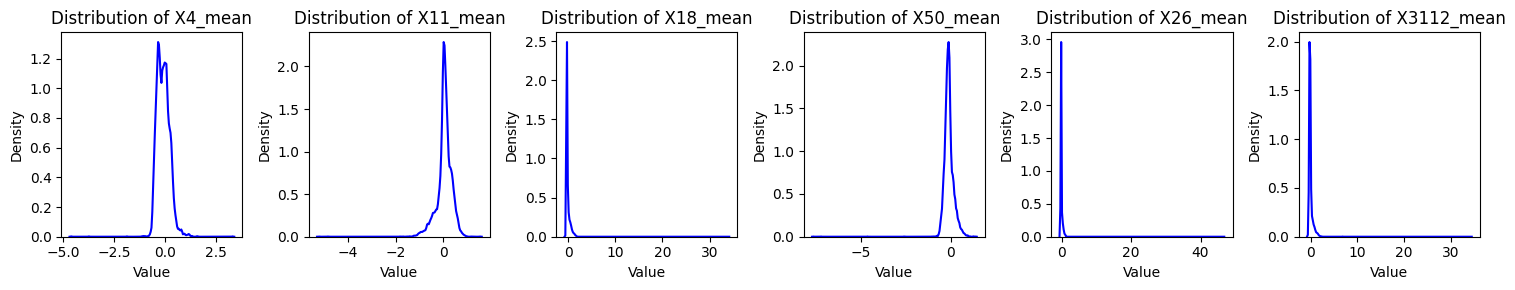

NaN values
 X4_mean       0
X11_mean      0
X18_mean      0
X50_mean      0
X26_mean      0
X3112_mean    0
dtype: int64


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
0,0.192746,-0.368328,-0.172221,0.038093,-0.153736,-0.360410
1,-0.353105,0.196391,-0.312582,-0.054351,-0.190246,-0.251815
2,-0.300847,0.038450,-0.333156,0.067670,-0.170850,-0.310316
3,-0.382025,0.309768,-0.312374,-0.240633,-0.195076,-0.202327
4,-0.056257,-0.596540,-0.439654,0.252970,-0.101474,-0.432604
...,...,...,...,...,...,...
6540,0.320657,-0.423150,-0.014434,0.273392,-0.078710,-0.297525
6541,0.355342,0.075085,1.353662,-0.250423,0.941022,1.742271
6542,-0.097134,0.460295,-0.061051,-0.385259,0.015691,0.200464
6543,-0.405103,0.500678,-0.124228,-0.462457,-0.135474,-0.270061


In [ ]:
test = pd.concat([test.reset_index(drop=True), predictions_df], axis=1)

plot_data(test)

print("NaN values\n", test[mean_columns].isna().sum())
test[mean_columns]

{'X4_mean': 0.5132580073474453, 'X11_mean': 15.765148295955713, 'X18_mean': 2.5532714084075927, 'X50_mean': 1.5793867083902597, 'X26_mean': 19.23601007117077, 'X3112_mean': 1474.5095177971766}
{'X4_mean': 0.1370688160962938, 'X11_mean': 6.837220942458856, 'X18_mean': 4.221007205367606, 'X50_mean': 0.5847983130736354, 'X26_mean': 52.72485086803302, 'X3112_mean': 2014.639313256618}


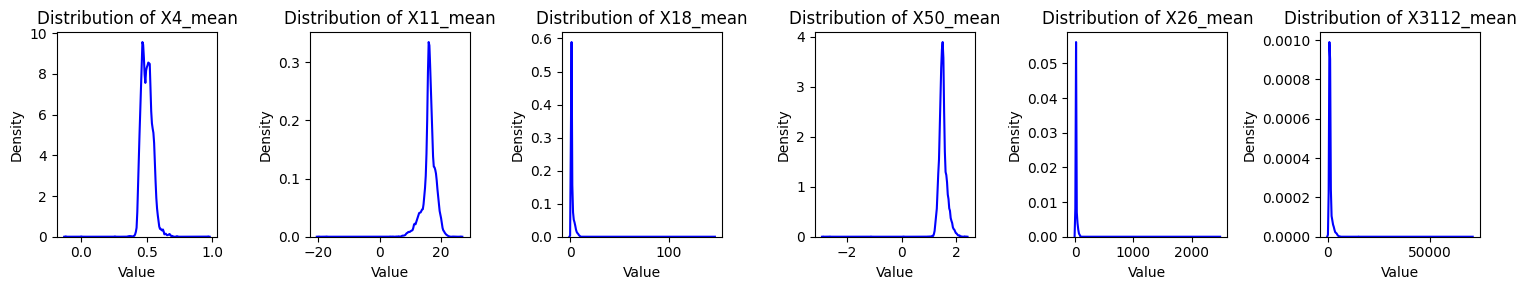

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
0,0.539678,13.246807,1.826324,1.601663,11.130322,748.413208
1,0.464858,17.107918,1.233862,1.547603,9.205298,967.193970
2,0.472021,16.028036,1.147019,1.618960,10.227950,849.334778
3,0.460894,17.883102,1.234740,1.438665,8.950640,1066.894531
4,0.505547,11.686474,0.697489,1.727323,13.885801,602.969238
...,...,...,...,...,...,...
6540,0.557210,12.871977,2.492346,1.739266,15.086021,875.103394
6541,0.561964,16.278519,8.267091,1.432940,68.851227,4984.556641
6542,0.499944,18.912289,2.295573,1.354088,20.063307,1878.371704
6543,0.457731,19.188398,2.028903,1.308943,12.093183,930.433960


In [ ]:
print(original_means)
print(original_stds)
for column in mean_columns:
    original_mean = original_means[column]
    original_std = original_stds[column]

    # Reverse the standardization
    test[column] = test[column] * original_std + original_mean

plot_data(test)
test[mean_columns]

In [ ]:
test.columns

Index(['id', 'WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg',
       ...
       'VOD_X_1997_2018_multiyear_mean_m10',
       'VOD_X_1997_2018_multiyear_mean_m11',
       'VOD_X_1997_2018_multiyear_mean_m12', 'image_path', 'X4_mean',
       'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean'],
      dtype='object', length=171)

In [ ]:
test = test[['id'] + mean_columns]

#rename from _mean
test.columns = test.columns.str.replace('_mean', '')
test.to_csv('submission.csv', index=False)

test

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.539678,13.246807,1.826324,1.601663,11.130322,748.413208
1,202310319,0.464858,17.107918,1.233862,1.547603,9.205298,967.193970
2,202604412,0.472021,16.028036,1.147019,1.618960,10.227950,849.334778
3,201353439,0.460894,17.883102,1.234740,1.438665,8.950640,1066.894531
4,195351745,0.505547,11.686474,0.697489,1.727323,13.885801,602.969238
...,...,...,...,...,...,...,...
6540,195548469,0.557210,12.871977,2.492346,1.739266,15.086021,875.103394
6541,199261251,0.561964,16.278519,8.267091,1.432940,68.851227,4984.556641
6542,203031744,0.499944,18.912289,2.295573,1.354088,20.063307,1878.371704
6543,197736382,0.457731,19.188398,2.028903,1.308943,12.093183,930.433960
